## NYC 311 Calls Dashboard
#### To Do:
- multiprocessing/threading to get more data?
- create cleaner categories; streamline google sheets pipeline?
- bargraph: fix sizing, finalize categories
- heatmap: more than one heatmap on a page?
- geomap: finalize map type, fix slider

### Setup / Import Data

In [128]:
import pandas as pd
import numpy as np
import requests
from sodapy import Socrata
import os
import seaborn as sns
from matplotlib import pyplot as plt
import sys
from fuzzywuzzy import process
from fuzzywuzzy import fuzz
import pygsheets
from datetime import datetime, date, time 
import json

from bokeh.plotting import figure, output_file, output_notebook, show, save, reset_output, gmap
from bokeh.models import ColumnDataSource, GMapOptions, HoverTool, BasicTicker, ColorBar, LinearColorMapper, PrintfTickFormatter, Panel, Tabs, CheckboxButtonGroup, CheckboxGroup, RadioButtonGroup, TextInput, Slider, DateRangeSlider
from bokeh.palettes import Spectral6, all_palettes, brewer
from bokeh.transform import factor_cmap, transform, linear_cmap
from bokeh.layouts import column, row, layout, WidgetBox
from bokeh.io import output_file, show, curdoc
from bokeh.sampledata.unemployment1948 import data
from bokeh.application import Application
from bokeh.application.handlers import FunctionHandler

import warnings
warnings.simplefilter("ignore")

pd.options.display.max_columns=50

In [85]:
#define parameters for endpoint, dataset, and app token
data_url = 'data.cityofnewyork.us'
dataset = 'erm2-nwe9'
app_token = 'dM7DDeidbAmgtydtJVV1epbiU'

#sets up the connection, need application token to override throttling limits
#username and password only required for creating or modifying data
client = Socrata(data_url, app_token)
client.timeout = 6000

#count number of records in desired dataset
record_count = client.get(dataset, select='count(*)', where="created_date >='2020-01-01'")
total_count = record_count[0]['count']
print(total_count)

737048


In [97]:
def get_data(chunk_size=100000, total_rows=int(total_count)):
    start = 0
    results=[]

    #paginate through dataset in sets of 10000 to get all records since 2019
    while True:
        print(f'{start} rows retrieved')
        results.extend(client.get(dataset,select="unique_key, created_date, closed_date, agency, agency_name, complaint_type, descriptor, location_type, incident_zip, borough, address_type, city, status, latitude, longitude, location", where="created_date >= '2020-02-01'", 
                                  limit=chunk_size, offset=start))
        start += chunk_size
        if start > total_rows:
            break
    return results

##### Only run if getting new data

In [98]:
# orig_results = get_data()
# orig_df = pd.DataFrame(orig_results)
# path = '/Users/linyu/Documents/Python/data/'
# orig_df.to_csv(path+'311_data.csv', index=False)

0 rows retrieved
100000 rows retrieved
200000 rows retrieved
300000 rows retrieved
400000 rows retrieved
500000 rows retrieved
600000 rows retrieved
700000 rows retrieved


In [100]:
# def reduce_memory(df):
#     """improved version of memory reduction function. uses pd.to_numeric to downcast types;
#     also considers whether there are few enough unique values to warrant use of category vs. object."""
#     orig_size = df.memory_usage().sum()/1024**2
#     dtypes = df.dtypes.astype(str).unique()
#     converted_float = pd.DataFrame()
#     converted_int = pd.DataFrame()
#     converted_obj = pd.DataFrame()
#     converted_misc = pd.DataFrame()

#     #convert floats
#     selected_float = df.select_dtypes(include='float')
#     converted_float = selected_float.apply(pd.to_numeric, downcast='float')
#     float_size = selected_float.memory_usage().sum()/1024**2
#     converted_float_size = converted_float.memory_usage().sum()/1024**2
#     print(f'floats: {float_size:.2f} reduced to {converted_float_size:.2f} MB')

#     #convert ints
#     selected_int = df.select_dtypes(include='integer')
#     converted_int = selected_int.apply(pd.to_numeric, downcast='integer')
#     int_size = selected_int.memory_usage().sum()/1024**2
#     converted_int_size = converted_int.memory_usage().sum()/1024**2
#     print(f'ints: {int_size:.2f} reduced to {converted_int_size:.2f} MB')
    
#     #convert objects / categories
#     selected_object = df.select_dtypes(include=['object', 'category'])
#     obj_size = selected_object.memory_usage().sum()/1024**2
#     for col in selected_object.columns:
#         count = len(selected_object[col])
#         unique = len(selected_object[col].astype(str).unique())
#         if unique < count/2:
#             converted_obj[col] = selected_object[col].astype(str).astype('category')
#         else:
#             converted_obj[col] = selected_object[col].astype(str)
#     converted_obj_size = converted_obj.memory_usage().sum()/1024**2
#     print(f'object: {obj_size:.2f} reduced to {converted_obj_size:.2f} MB')

#     #join floats, ints, and objects / categories
#     float_int = converted_float.join(converted_int)
#     float_int_obj = float_int.join(converted_obj)
    
#     #for any columns of any other type, keep them the same and join to the converted dataframe
#     no_change_cols = [x for x in df.columns if x not in float_int_obj.columns]
#     reduced_df = float_int_obj.join(df[no_change_cols])
    
#     #re-order columns to appear in original order
#     reduced_df = reduced_df[df.columns]
#     reduced_size = reduced_df.memory_usage().sum()/1024**2
#     print(f'final df: {orig_size:.2f} reduced to {reduced_size:.2f} MB, {(orig_size-reduced_size)/orig_size*100:.1f}% reduction')
#     return reduced_df

In [101]:
#need to fix this - relative path
user = 'linyu'
path = '/Users/'+user+'/Documents/Python/data/'
orig_df = pd.read_csv(path+'311_data.csv', usecols=['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
                                                 'complaint_type', 'descriptor', 'location_type', 'incident_zip', 'borough',
                                                 'address_type', 'city', 'status', 'latitude', 'longitude', 'location'], parse_dates=['created_date', 'closed_date'])

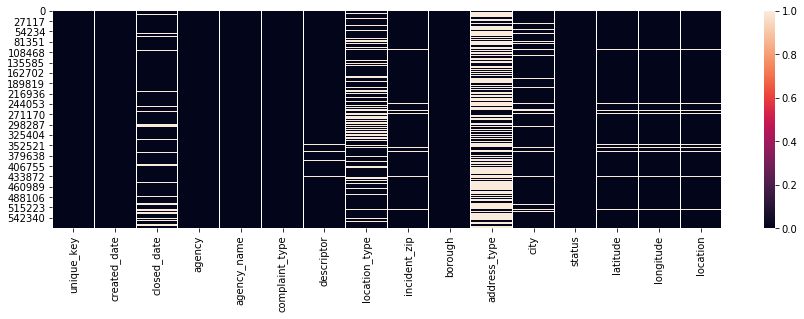

In [102]:
# #display null values per column
# plt.rc('figure',figsize=(15,4))
# display(sns.heatmap(orig_df.isnull()))

## Data Processing
- need to create a function that will show the new, unmapped categories for each new imported dataset
- need to indicate column types upon reading in with pandas, use the reduce memory function after preprocessing

In [103]:
##ingest all datetime as datetimes
#leave strings as objects, integers as ints, floats as floats
#specifically cast columns you want to change to diff dtype
#use categorical if you're going to be grouping by (cardinality<1000)

In [104]:
def preprocess(df):
    #look into vectorized functions
    #note: .apply not vectorized, slow
    df['created_mdy'] = df['created_date'].dt.date
    df['created_year'] = df['created_date'].dt.year
    df['created_month'] = df['created_date'].dt.month
    df['created_day'] = df['created_date'].dt.day
    df['created_weekday'] = df['created_date'].dt.day_name()
    df['created_week'] = df['created_date'].dt.week
    df['created_hour'] = df['created_date'].dt.hour
    df['days_to_close'] = (df['closed_date'] - df['created_date']).dt.days
    df['count'] = 1
    df['hour'] = [x.strftime('%I %p') for x in df['created_date']]
    
    df['agency_name'] = df['agency_name'].astype('category')
    df['complaint_type'] = df['complaint_type'].astype('category')
    df['descriptor'] = df['descriptor'].astype('category')
    df['location_type'] = df['location_type'].astype('category')
    df['city'] = df['city'].astype('category')
    return df

In [105]:
new_df = preprocess(orig_df)

In [106]:
def export_col_values(workbook, df, columns):
    """for a list of columns, creates a new sheet for each column and exports unique values and their counts to that sheet"""
    for col in columns:
        value_counts = df[col].value_counts()
        counts_df = pd.DataFrame(value_counts).reset_index()
        #was getting an error with using fillna for categorical column, need to cast to string
        counts_df['index'] = counts_df['index'].astype(str)
        try:
            worksheet = workbook.worksheet_by_title(col)
        except Exception:
            #ensure the error is in regards to missing the worksheet
            print(sys.exc_info())
            workbook.add_worksheet(col)
            worksheet = workbook.worksheet_by_title(col)
        worksheet.set_dataframe(counts_df, start='A1')
    print(f'{len(columns)} sets of column values exported.')
        
def get_valid_names(workbook, columns, start='D1'):
    """extracts the valid names manually entered by the user in column D of the workbook"""
    valid_names = {}
    for col in columns:
        worksheet = workbook.worksheet_by_title(col)
        valid_matrix = worksheet.get_values(start='D1', end='D100')
        valid_names[col] = [v[0] for v in valid_matrix]
    return valid_names

def fuzzy_match(value):
    """returns the best match for each column; fuzzy match score of < 90 will return 'Other'"""
    match = process.extract(query=value, choices=valid_names[col], limit=1)
    if match[0][1] < 90:
        return 'Other'
    else:
        return match[0][0]

In [107]:
#use pygsheets to connect to workbook where we will export unique column values
client = pygsheets.authorize(service_account_file=path+'client_secret.json')
workbook = client.open('311_data_cleaning')
columns = ['agency_name','complaint_type','descriptor','location_type','city']

#export unique column values and their counts
export_col_values(workbook, new_df, columns)

5 sets of column values exported.


In [108]:
#get dictionary of lists with valid names for each column
#change values in column D of each tab if you wish to change the possible output values
valid_names = get_valid_names(workbook, columns, start='D1')

#fuzzy match each of the columns to the available values
for col in columns:
    new_df['cleaned_'+col] = new_df[col].apply(fuzzy_match)

In [109]:
nyc_311_calls = new_df.copy()

## Bokeh Visualizations
- function to create bar graphs
- function to create tables
- function to create heatmaps
- function to create geo map
- function to create call outs
- add visualizations and sliders to dashboard

### Heatmap with Controls

In [269]:
def heatmap_tab(nyc_311_calls, x, y, value, title=None, x_ticks=None, y_ticks=None, exclude=None):
    
    def make_dataset(x, y, value):
        pivot = nyc_311_calls.pivot_table(values=value, index=x, columns=y, aggfunc='sum')
        pivot.columns = pivot.columns.astype(str)
        pivot.index = pivot.index.astype(str)
        if exclude:
            try:
                pivot = pivot.drop(exclude)
                print(f'{exclude} dropped from index.')
            except KeyError:
                print(f'{exclude} dropped from columns.')
                pivot = pivot.drop(exclude, axis=1)
            except:
                print('Exclusion does not exist in index or columns.')
        df_pivot = pd.DataFrame(pivot.stack()).reset_index()
        df_pivot.columns = ['y','x','value']
        return ColumnDataSource(df_pivot)
    
    def make_plot(src):
        colors = ["#75968f", "#a5bab7", "#c9d9d3", "#e2e2e2", "#dfccce", "#ddb7b1", "#cc7878", "#933b41", "#550b1d"]
        mapper = LinearColorMapper(palette=colors, low=src.data['value'].min(), high=src.data['value'].max())
        
        if x_ticks:
            x_range = x_ticks
        else:
            x_range = sorted(list(set(src.data['x'])))
        
        if y_ticks:
            y_range = y_ticks
        else:
            y_range = sorted(list(set(src.data['y'])))
        
        p = figure(plot_width=900, plot_height=500, x_range=x_range, 
                   y_range = y_range, title = title)
        p.rect(x='x', y='y', width=1, height=1, source=src, line_color='white', fill_color=transform('value', mapper))
        color_bar = ColorBar(color_mapper=mapper, location=(0,0), ticker=BasicTicker(desired_num_ticks=len(colors)))
        p.add_layout(color_bar, 'right')
        hover = HoverTool(tooltips=[(x,'@x'),(y,'@y'), (value,'@value')])
        p.add_tools(hover)
        p.grid.visible=False
        p.axis.axis_line_color = None
        p.axis.major_tick_line_color = None
        p.axis.major_label_text_font_size = "11px"
        p.axis.major_label_standoff = 0
        p.xaxis.major_label_orientation = 1.0
        return p
    
    def update(attr, old, new):
        dates_to_plot = date_range_slider.value
        
    date_range_slider = DateRangeSlider(title="Date Range: ", start=date(2020, 1, 1), end=date.today(), value=(date(2020, 1, 1), date.today()), step=1)
    date_range_slider.on_change('value',update)
                                        
    src = make_dataset(x, y, value)
    plot = make_plot(src)
    
    controls=WidgetBox(date_range_slider)
    layout = column(controls, plot)
    tab = Panel(child=layout, title='Heatmap')
    return tab


### Geomap with Controls

In [274]:
def geomap_tab(nyc_311_calls):
    path = '/Users/linyu/Documents/Python/data/'
    map_path = '/Users/linyu/Documents/Python/personal_projects/NYC_311_Calls/'
    with open(map_path+'map_style.txt') as json_file:
        map_style_json = json.load(json_file)
    map_style = json.dumps(map_style_json)
    
    def make_dataset(boroughs, display_num, start_date, end_date):
        date_filter = nyc_311_calls[(nyc_311_calls['created_mdy'] >= start_date) & (nyc_311_calls['created_mdy'] <= end_date)]
        borough_filter = date_filter[date_filter['borough'].isin(boroughs)]
        borough_filter['lat_round'] = round(borough_filter['latitude'],3)
        borough_filter['lon_round'] = round(borough_filter['longitude'],3)
        latlon_df = pd.DataFrame(borough_filter.groupby(['lat_round', 'lon_round'])['count'].sum()).reset_index()
        latlon_df['sizes'] = latlon_df['count']/latlon_df['count'].max()*50
        latlon_sorted = latlon_df.sort_values('sizes', ascending=False)
        latlon_display = latlon_sorted[:display_num]
        return ColumnDataSource(latlon_display)
    
    def style(p):
        p.title.align = 'center'
        p.title.text_font_size = '15pt'
        p.title.text_font = 'serif'

        p.xaxis.axis_label = 'Latitude'
        p.xaxis.axis_label_text_font_size = '10pt'
        p.yaxis.axis_label = 'Longitude'
        p.yaxis.axis_label_text_font_size = '10pt'

        p.xaxis.major_label_text_font_size = '8pt'
        p.yaxis.major_label_text_font_size = '8pt'
        return p
        
    def make_plot(src):
        with open(path+'client_secret.json') as f:
            data = json.load(f)
        api_key = data['google_api_key']
        map_options = GMapOptions(lat=40.76, lng=-73.95, map_type='roadmap', zoom=11, styles=map_style)
        call_map = gmap(api_key, map_options, title='311 Calls by Location')
        call_map.circle(x='lon_round', y='lat_round', size='sizes', source=src, fill_alpha = 0.8, 
                        fill_color='salmon', line_color='firebrick')
        
        hover = HoverTool(tooltips=[('longitude','@lon_round'),('latitude','@lat_round'), ('count','@count')])
        call_map.add_tools(hover)
        call_map = style(call_map)
        return call_map
    
    def update(attr, old, new):
        boroughs_to_plot = [borough_selection.labels[i] for i in borough_selection.active]
        top_n = int(display_labels[radio_button_group.active][4:])
        start_date = pd.to_datetime(date_range_slider.value[0])
        end_date = pd.to_datetime(date_range_slider.value[1])
        new_src = make_dataset(boroughs_to_plot, top_n, start_date, end_date)
        src.data.update(new_src.data)
        
    available_boroughs = list(set(nyc_311_calls['borough']))
    available_boroughs.sort()
    
    #checkbox for neighborhoods
    borough_selection = CheckboxGroup(labels=available_boroughs, active=[0,1,2,3,4])
    borough_selection.on_change('active', update)
    
    #radio button for top N records to display
    display_labels = ['Top 5', 'Top 100', 'Top 1000', 'Top 5000']
    radio_button_group = RadioButtonGroup(labels=display_labels, active=1)
    radio_button_group.on_change('active', update)
    
    #slider for date range
    date_range_slider = DateRangeSlider(title="Date Range", start=date(2020, 1, 1), end=date.today(), value=(date(2020, 1, 1), date.today()), step=1)
    date_range_slider.on_change('value', update)
    
    #set initial dataset params
    initial_boroughs = [borough_selection.labels[i] for i in borough_selection.active]
    start_date = pd.to_datetime(date_range_slider.value[0])
    end_date = pd.to_datetime(date_range_slider.value[1])
    top_n = int(display_labels[radio_button_group.active][4:])
    
    #create initial plot
    src = make_dataset(initial_boroughs, display_num=top_n, start_date=start_date, end_date=end_date)
    p = make_plot(src)
    controls = WidgetBox(date_range_slider, radio_button_group, borough_selection)
    layout = row(controls, p)
    tab = Panel(child=layout, title='Geomap')
    tabs = Tabs(tabs=[tab], background='black')
    return tab

SyntaxError: EOL while scanning string literal (<ipython-input-274-51ad3aa682d8>, line 2)

### Bar Graph with Controls

In [271]:
def bargraph_tab(nyc_311_calls, categories=['cleaned_descriptor']):
    
    def make_dataset(category, value, num_categories):
        grouped_df = pd.DataFrame(nyc_311_calls.groupby(category)[value].sum()).reset_index()
        grouped_df[category] = grouped_df[category].astype(str)
        grouped_df = grouped_df.sort_values(value, ascending = False)[:num_categories]
        colors = ['#550b1d', '#933b41', '#cc7878', '#ddb7b1', '#dfccce', '#e2e2e2', '#c9d9d3', '#a5bab7', '#75968f']
        try:
            grouped_df['color'] = colors[:num_categories]
        except KeyError:
            print('Too many categories selected; select up to 9 categories to display')
        return ColumnDataSource(grouped_df)
        
    def style(p):
        p.xgrid.visible = False
        p.ygrid.visible = False
        p.toolbar.logo = None
        p.toolbar_location = None        
        return p
    
    def make_plot(src):
        output_file = ('test.html')
        p = figure(y_range = list(reversed(src.data[category])), plot_height=300, plot_width=600, 
                  x_axis_label='Calls')
        
#         mapper = LinearColorMapper(palette=colors, low=src.data['value'].min(), high=src.data['value'].max())
        p.hbar(y=category, right=value, source=src, height=0.8, color='color', hover_color='white')
        category_value = f'@{category}'
        value_value = f'@{value}'
        hover = HoverTool(tooltips=[(category, category_value), (value, value_value)])
        p.add_tools(hover)
        p = style(p)
        return p
        
    def update():
        pass
    
    value='count'
    num_categories=8
    
    date_range_slider = DateRangeSlider(title="Date Range: ", start=date(2020, 1, 1), end=date.today(), value=(date(2020, 1, 1), date.today()), step=1)
    controls = WidgetBox(date_range_slider)

    plots = {}
    for i, category in enumerate(categories):
        src = make_dataset(category, value, num_categories)
        p = make_plot(src)
        plots[i] = p
    
    row_1 = row(plots[2], plots[3])
    row_2 = row(plots[0], plots[1])
    layout = column(controls, row_1, row_2)
    tab = Panel(child=layout, title='Bar Graph')
    tabs = Tabs(tabs=[tab], background='#000000')
    return tab

In [272]:
nyc_311_calls.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,borough,address_type,city,status,latitude,longitude,location,created_mdy,created_year,created_month,created_day,created_weekday,created_week,created_hour,days_to_close,count,hour,cleaned_agency_name,cleaned_complaint_type,cleaned_descriptor,cleaned_location_type,cleaned_city
0,45526178,2020-02-01,2020-02-07 00:00:01,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,11105.0,QUEENS,ADDRESS,Astoria,Closed,40.773719,-73.907302,"{'latitude': '40.77371881330934', 'longitude':...",2020-02-01,2020,2,1,Saturday,5,0,6.0,1,12 AM,Department of Health and Mental Hygiene,Other,Other,Restaurant,Astoria
1,45523921,2020-02-01,2020-02-07 00:00:01,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Other (Explain Below),11232.0,BROOKLYN,ADDRESS,BROOKLYN,Closed,40.648864,-74.006422,"{'latitude': '40.64886377225159', 'longitude':...",2020-02-01,2020,2,1,Saturday,5,0,6.0,1,12 AM,Department of Health and Mental Hygiene,Other,Other,Other,Brooklyn
2,45523230,2020-02-01,2020-02-07 00:00:01,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,11101.0,QUEENS,ADDRESS,Long Island City,Closed,40.744650,-73.953471,"{'latitude': '40.74464967112952', 'longitude':...",2020-02-01,2020,2,1,Saturday,5,0,6.0,1,12 AM,Department of Health and Mental Hygiene,Other,Other,Restaurant,Long Island City
3,45522501,2020-02-01,2020-02-03 00:00:01,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,11203.0,BROOKLYN,ADDRESS,BROOKLYN,Closed,40.655901,-73.942021,"{'latitude': '40.65590068417525', 'longitude':...",2020-02-01,2020,2,1,Saturday,5,0,2.0,1,12 AM,Department of Health and Mental Hygiene,Other,Other,Restaurant,Brooklyn
4,45522448,2020-02-01,2020-02-03 00:00:01,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,11361.0,QUEENS,ADDRESS,Bayside,Closed,40.756309,-73.767436,"{'latitude': '40.756309068699075', 'longitude'...",2020-02-01,2020,2,1,Saturday,5,0,2.0,1,12 AM,Department of Health and Mental Hygiene,Other,Other,Restaurant,Other


In [273]:
time = ['11 PM', '10 PM', '09 PM', '08 PM', '07 PM', '06 PM', '05 PM', '04 PM', '03 PM', '02 PM', '01 PM', '12 PM', '11 AM', '10 AM', '09 AM', '08 AM', '07 AM', '06 AM', '05 AM', '04 AM', '03 AM', '02 AM', '01 AM', '12 AM']

heatmap = heatmap_tab(nyc_311_calls, 'hour','created_weekday','count', 'Calls by Day and Hour', y_ticks=time,
                     x_ticks=['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])

heatmap2 = heatmap_tab(nyc_311_calls, 'cleaned_descriptor','created_week','count', 'Calls by Type', exclude='Other')

geomap = geomap_tab(nyc_311_calls)

bargraph = bargraph_tab(nyc_311_calls, ['agency','cleaned_descriptor','cleaned_city', 'cleaned_location_type'])

tabs = Tabs(tabs=[bargraph, heatmap, heatmap2, geomap])
output_file('dashboard.html')
show(tabs)
#curdoc().theme = 'dark_minimal'
#curdoc().add_root(tabs)

Other dropped from index.


FileNotFoundError: [Errno 2] No such file or directory: '/Users/linyu/Documents/Python/personal_projects/NYC_311_Calls/client_secret.json'

In [254]:
# ##line graph
# clean_processed['cleaned_descriptor'] = clean_processed['cleaned_descriptor'].astype(str)
# clean_processed['created_mdy'] = clean_processed['created_mdy'].astype(str)
# pivot = clean_processed.pivot_table(values='count', index='created_mdy', columns='cleaned_descriptor', aggfunc=sum).reset_index()
# source = ColumnDataSource(pivot)

# reset_output()
# linegraph = figure(x_range=pivot['created_mdy'])
# for col in pivot.columns:
#     linegraph.line(x='created_mdy', y = col, source=source, color='red', legend='test')
# factor_cmap(field_name='test', palette='Viridis256', factors=pivot.columns)

# hover = HoverTool(tooltips=[("Date","@created_mdy"),("Ceiling","@Ceiling")])
# linegraph.add_tools(hover)
# show(linegraph)